# Agentic RAG for complex question answering

### CRAG
[Corrective-RAG (CRAG)](https://arxiv.org/abs/2401.15884) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents. \
I combine this framework with complex query decomposition, and formulate the larger system as a graph.
![query](img/query-decomp.png)
![CRAG](img/CRAG1.png)
![system](img/system.png)
### LangGraph
We will implement this agent as a custom / user-defined control flow in LangGraph, as illustrated in the two graphs below

![agent](img/agent.jpg)
![CRAG_graph](img/CRAG_graph.jpg)

### Tools / Externals
We'll use [Tavily](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

We'll use an elasticsearch vectorstore with watsonx slate embeddings


In [ ]:
!pip install ibm-watsonx-ai
!pip install langchain
!pip install langchain-community
!pip install langchain-ibm
!pip install langgraph
!pip install elasticsearch
!pip install langchain-elasticsearch
!pip install elastic-transport
!pip install dotenv

In [1]:
import os
project_id = os.getenv("GENAI_PROJECT_ID")
api_key = os.getenv("GENAI_KEY")
#WatsonX discovery 
url = os.getenv("WXD_URL", None)
username= os.getenv("WXD_USERNAME", None)
password = os.getenv("WXD_PASSWORD", None)
credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": api_key
}

## Custom LangGraph Agent

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

In [3]:
# from langchain_elasticsearch import ElasticsearchStore
from elasticsearch import Elasticsearch

es_client = Elasticsearch(
    url,
    basic_auth=(username,password),
    verify_certs=False,
    request_timeout=3600,)

/Users/deansacoransky/Documents/GitHub/agenticai/venv/lib/python3.11/site-packages/elasticsearch/_sync/client/__init__.py:399: SecurityWarning: Connecting to 'https://0e82c807-e2be-427f-bb35-0d90c2077542.6131b73286f34215871dfad7254b4f7d.databases.appdomain.cloud:30189' using TLS with verify_certs=False is insecure
  _transport = transport_class(


In [2]:
import os
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenTextParamsMetaNames
from langchain_elasticsearch import ElasticsearchStore
from elasticsearch import Elasticsearch
from langchain.document_loaders.parsers.html import bs4
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

#WatsonX discovery 
url = os.getenv("WXD_URL", None)
username= os.getenv("WXD_USERNAME", None)
password = os.getenv("WXD_PASSWORD", None)

es_client = Elasticsearch(
    url,
    basic_auth=(username,password),
    verify_certs=False,
    request_timeout=3600)

embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

index_name = "dean-test"
if es_client.indices.exists(index=index_name):
    # from langchain_huggingface.embeddings import HuggingFaceEmbeddings
    # Define embeddings model: dimension [1024]
    # embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")
    # Load existing index from vectorstore
    vectorstore = ElasticsearchStore(
        es_connection=es_client,
        embedding=embeddings,
        index_name=index_name,
    )
    print("Load {} from ElasticsearchStore".format(index_name))
else:
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    from langchain_community.document_loaders import WebBaseLoader

    # List of URLs to load documents from
    urls = [
        "https://en.wikipedia.org/wiki/David_Fincher",
        "https://en.wikipedia.org/wiki/Brad_Pitt"
    ]
    # Load documents from the URLs
    docs = [WebBaseLoader(url).load() for url in urls]



    # # Load documents from the URLs
    # docs = [WebBaseLoader(web_path=url,
    #                       bs_kwargs=dict(
    #                           parse_only=bs4.SoupStrainer(
    #                               id="docs-content"
    #                           )
    #                       )).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]

    # Initialize a text splitter with specified chunk size and overlap
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=250, chunk_overlap=0
    )

    # Split the documents into chunks
    doc_splits = text_splitter.split_documents(docs_list)

    # Build index to vectorstore
    vectorstore = ElasticsearchStore.from_documents(
        documents=doc_splits,
        es_connection=es_client,
        embedding=embeddings,
        index_name=index_name,
    )
    vectorstore.client.indices.refresh(index=index_name)
    print("Create {} in ElasticsearchStore".format(index_name))
    
retriever = vectorstore.as_retriever()


/Users/deansacoransky/Documents/GitHub/agenticai/venv/lib/python3.11/site-packages/elasticsearch/_sync/client/__init__.py:399: SecurityWarning: Connecting to 'https://0e82c807-e2be-427f-bb35-0d90c2077542.6131b73286f34215871dfad7254b4f7d.databases.appdomain.cloud:30189' using TLS with verify_certs=False is insecure
  _transport = transport_class(
/Users/deansacoransky/Documents/GitHub/agenticai/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '0e82c807-e2be-427f-bb35-0d90c2077542.6131b73286f34215871dfad7254b4f7d.databases.appdomain.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/deansacoransky/Documents/GitHub/agenticai/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '0e82c807-e2be-427f-bb35-0d90c20

Create dean-test in ElasticsearchStore


/Users/deansacoransky/Documents/GitHub/agenticai/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '0e82c807-e2be-427f-bb35-0d90c2077542.6131b73286f34215871dfad7254b4f7d.databases.appdomain.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
!pip install langchain_huggingface


In [4]:
from langchain_elasticsearch import ElasticsearchStore

#load existing vectorstore
vectorstore = ElasticsearchStore(
    es_connection=es_client,
    embedding = embedding_function,
    index_name="gd_wd_docs_mxbai_l_no_overlap_icd",
)

In [5]:
retriever = vectorstore.as_retriever()

In [6]:
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [7]:
#define LLM
llm = WatsonxLLM(
    model_id = "meta-llama/llama-3-405b-instruct",
    url=credentials.get("url"),
    apikey=credentials.get("apikey"),
    project_id=project_id,
    params = {  GenTextParamsMetaNames.DECODING_METHOD: "greedy",
                GenTextParamsMetaNames.MAX_NEW_TOKENS: 200,
                GenTextParamsMetaNames.MIN_NEW_TOKENS: 10
             })
#define LLM
# llm_query_decompose = WatsonxLLM(
#     model_id = "meta-llama/llama-3-405b-instruct",
#     url=credentials.get("url"),
#     apikey=credentials.get("apikey"),
#     project_id=project_id,
#     params = {  GenTextParamsMetaNames.DECODING_METHOD: "greedy",
#                 GenTextParamsMetaNames.MAX_NEW_TOKENS: 200,
#                 GenTextParamsMetaNames.MIN_NEW_TOKENS: 10
#              })

In [8]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>You are an assistant for question-answering tasks. 
    {{Below is some context from different sources followed by a user's question. Please answer the question based on the context.
    
    Documents: {documents}}} <|eot_id|><|start_header_id|>user<|end_header_id|>
    
    {{ Question: {question} }}<|eot_id|><|start_header_id|>assistant<|end_header_id|> 
    
    Answer:
    """,
    input_variables=["question", "documents"],
)

#define rag chain
rag_chain = prompt | llm | StrOutputParser()

In [9]:
from langchain_core.output_parsers import JsonOutputParser

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the user question: {question} \n
    
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

#define retieval grader chain
retrieval_grader = prompt | llm | JsonOutputParser()

In [10]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an assistant for question-answering tasks. 
    Perform query decomposition. Given a user question, break it down into distinct sub questions that \
    you need to answer in order to answer the original question. Response with \"The question needs no decomposition\" when no decomposition is needed.
    Generate questions that explicitly mention the subject by name, avoiding pronouns like 'these,' 'they,' 'he,' 'she,' 'it,' etc. Each question should clearly state the subject to ensure no ambiguity. 
    
    Example 1:
    Question: Is Hamlet more common on IMDB than Comedy of Errors?
    Decompositions: 
    How many listings of Hamlet are there on IMDB?
    How many listing of Comedy of Errors is there on IMDB?
    
    Example 2:
    Question: What is the Capital city of Japan?
    Decompositions:
    The question needs no decomposition
    
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {user_query} <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    Decompositions:"
    """,
    input_variables=["user_query"],
)

#define query decomposition chain
query_decompose = prompt | llm| StrOutputParser()

In [11]:
from typing_extensions import TypedDict, List
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph

class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question to be used as input in LLM chain
        generation: LLM generation response
        search: "yes" or "no" string acting as boolean for whether to invoke web search
        documents: list of documents for in-context learning
        steps: List of steps taken in agent flow
        user_query: original user query, stored here for persistence during consolidation stage
        sub_answers: list of answers to decomposed questions
    """
    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]
    user_query: str
    sub_answers: List[str]
    sub_questions: List[str]
    
def retrieve(state):
    """
    Retrieve documents
    This is the first Node invoked in the CRAG_graph
    
    # CRAG_graph is invoked in the CRAG_loop node:
    #response = CRAG_graph.invoke({"question": q, "steps": steps})["generation"]
    #we initialize the state with a sub-question and list of steps

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---Retrieving Documents---")
    """-----------inputs-----------"""
    question = state["question"]
    steps = state["steps"]
    
    """-----------actions-----------"""
    steps.append("retrieve_documents")
    documents = retriever.invoke(question)
    
    """-----------outputs-----------"""
    return {
        "documents": documents, 
        "question": question, 
        "steps": steps
    }
    
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question. Store all relevant documents to the documents dictionary. 
    However, if there is even one irrelevant document, then websearch will be invoked.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---Grading Retrieved Documents---")
    """-----------inputs-----------"""
    documents = state["documents"]
    question = state["question"]
    steps = state["steps"]
    
    """-----------actions-----------"""
    steps.append("grade_document_retrieval")
    relevant_docs = []
    search = "No"
    
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            relevant_docs.append(d)
        else:
            search = "Yes"
            continue
    """-----------outputs-----------"""
    return {
        "documents": relevant_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---At decision Edge---")
    """-----------inputs-----------"""
    search = state["search"]
    
    """-----------actions & outputs-----------"""
    if search == "Yes":
        return "search"
    else:
        return "generate"

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---Searching the Web---")
    """-----------inputs-----------"""
    documents = state.get("documents", [])
    question = state["question"]
    steps = state["steps"]
    
    """-----------actions-----------"""
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    """-----------outputs-----------"""
    return {
        "documents": documents, 
        "question": question, 
        "steps": steps
    }

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---Generating Response---")
    """-----------inputs-----------"""
    documents = state["documents"]
    question = state["question"]
    steps = state["steps"]

    """-----------actions-----------"""
    steps.append("generating sub-answer")
    generation = rag_chain.invoke({"documents": documents, "question": question})
    print("Response to subquestion:", generation)
    
    """-----------outputs-----------"""
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }

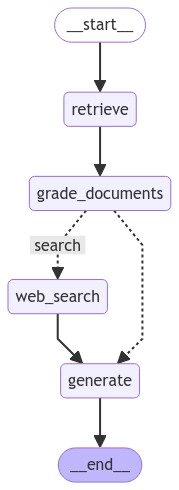

In [12]:
# intialize Graph
CRAG = StateGraph(GraphState)

# Define the nodes
CRAG.add_node("retrieve", retrieve)  # retrieve
CRAG.add_node("grade_documents", grade_documents)  # grade documents
CRAG.add_node("generate", generate)  # generatae
CRAG.add_node("web_search", web_search)  # web search

# Build graph
CRAG.set_entry_point("retrieve")
CRAG.add_edge("retrieve", "grade_documents")
CRAG.add_conditional_edges(
    "grade_documents",  #at grade_documents node, invoke decide_to_generate function
    decide_to_generate,
    {
        "search": "web_search", #if "search" is returned, invoke the "web_search" node
        "generate": "generate", #if "generate" is returned, invoke the "generate" node
    },
)
CRAG.add_edge("web_search", "generate")
CRAG.add_edge("generate", END)

CRAG_graph = CRAG.compile()

display(Image(CRAG_graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
def transform_query(state: dict) -> dict:
    """
    Transform the user_query to produce a list of simple questions.
    This is the first node invoked in the graph, with input user question and empty steps list
    response = agentic_rag.invoke({"user_query": question3, "steps": []})


    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a list of re-phrased question
    """
    """-----------inputs-----------"""
    user_query = state["user_query"]
    steps = state["steps"]
    print("User Query:", user_query)
    print("---Decomposing the QUERY---")
    
    """-----------actions-----------"""
    steps.append("transform_query")
    # Re-write question
    sub_questions = query_decompose.invoke({"user_query": user_query})
    
    #parse sub questions as a list
    list_of_questions = [question.strip() for question in sub_questions.strip().split('\n')]
    
    if list_of_questions[0] == 'The question needs no decomposition':
        #no query decomposition required
        #return question field as list
        """-----------outputs-----------"""
        return {
            "sub_questions": [user_query], 
            "steps": steps, 
            "user_query": user_query
        }
    else:
        print("Decomposed into the following queries:", list_of_questions)
        return {
            "sub_questions": list_of_questions, 
            "steps": steps, 
            "user_query": user_query
        }
    
def CRAG_loop(state: dict) -> dict:
    """
    Determines whether to invoke CRAG graph call.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    """-----------inputs-----------"""
    questions = state["sub_questions"] #list of questions
    steps = state["steps"]
    user_query = state["user_query"]   
    
    """-----------actions-----------"""
    sub_answers =[]
    steps.append("entering iterative CRAG for sub questions")
    
    #loop through list of decomposed questions
    for q in questions:
        print("Handling subquestion:", q)
        #enters beggining of CRAG graph -- retrieve node with the following state (question, step)
        response = CRAG_graph.invoke({"question": q, "steps": steps})["generation"]
        sub_answers.append(response)
    
    """-----------outputs-----------"""
    return {
            "sub_answers": sub_answers, 
            "sub_questions": questions, 
            "user_query": user_query
        }

def consolidate(state: dict) -> dict:
    """
    Generate consolidated final answer to the original question, given 1. the original question and 2. the sub_questions with corresponding sub_answers

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---Consolidating Response---")
    """-----------inputs-----------"""
    answers = state['sub_answers']
    questions = state['sub_questions']
    user_query = state['user_query']
    
    """-----------actions-----------"""
    steps = state["steps"]
    steps.append("generating final answer")
    qa_pairs = []
    
    #create a list of the decomposed questions with their corresponding answers
    #this intermediary information is used as context to answer the original user_query via in-context learning / RAG approach
    for i in range(min(len(questions), len(answers))):
        qa_pairs.append({questions[i]: answers[i].strip()})
    print("multi hop context", qa_pairs)
    final_response = rag_chain.invoke({"documents": qa_pairs, "question": user_query})
    print("Final Response to Original Query:", final_response)
    
    """-----------outputs-----------"""
    return {
        "user_query": user_query,
        "final_response": final_response,
        "steps": steps,
        "intermediate_qa": qa_pairs,
    }

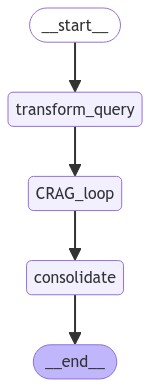

In [14]:
nested_CRAG = StateGraph(GraphState)
nested_CRAG.add_node("transform_query", transform_query)  # retrieve
nested_CRAG.add_node("CRAG_loop",CRAG_loop)
nested_CRAG.add_node("consolidate",consolidate)
nested_CRAG.set_entry_point("transform_query")
nested_CRAG.add_edge("transform_query", "CRAG_loop")
nested_CRAG.add_edge("CRAG_loop", "consolidate")
nested_CRAG.add_edge("consolidate", END)

agentic_rag = nested_CRAG.compile()

display(Image(agentic_rag.get_graph(xray=True).draw_mermaid_png()))

In [16]:
question1 = "Which David Fincher film that stars Edward Norton does not star Brad Pitt?"

response = agentic_rag.invoke({"user_query": question1, "steps": []})

User Query: Which David Fincher film that stars Edward Norton does not star Brad Pitt?
---Decomposing the QUERY---
Decomposed into the following queries: ['What David Fincher films star Edward Norton?', 'Which of the David Fincher films that star Edward Norton also star Brad Pitt?']
Handling subquestion: What David Fincher films star Edward Norton?
---Retrieving Documents---
---Grading Retrieved Documents---
---At decision Edge---
---Searching the Web---
---Generating Response---
Response to subquestion:  One David Fincher film that stars Edward Norton is Fight Club (1999).
Handling subquestion: Which of the David Fincher films that star Edward Norton also star Brad Pitt?
---Retrieving Documents---
---Grading Retrieved Documents---
---At decision Edge---
---Searching the Web---
---Generating Response---
Response to subquestion:  "Fight Club" is the David Fincher film that stars both Edward Norton and Brad Pitt.
---Consolidating Response---
multi hop context [{'What David Fincher films 

- to do: printing intermediary states for explainability
- add human-in-loop

User Query: Which David Fincher film that stars Edward Norton does not star Brad Pitt?

---Decomposing the QUERY---
Decomposed into the following queries: 
1. 'What David Fincher films star Edward Norton?'
2. 'Which of the David Fincher films that star Edward Norton also star Brad Pitt?'

Handling subquestion: 'What David Fincher films star Edward Norton?'
---Retrieving Documents---
---Grading Retrieved Documents---
---At decision Edge---
---Searching the Web---
---Generating Response---
Response to sub-question:  One David Fincher film that stars Edward Norton is Fight Club (1999).

Handling sub-question: 'Which of the David Fincher films that star Edward Norton also star Brad Pitt?'
---Retrieving Documents---
---Grading Retrieved Documents---
---At decision Edge---
---Searching the Web---
---Generating Response---
Response to subquestion:  "Fight Club" is the David Fincher film that stars both Edward Norton and Brad Pitt.

---Consolidating Response---
Final Response to Original Query:  
None, as there is only one mentioned David Fincher film starring Edward Norton, which is "Fight Club" and it stars Brad Pitt.